# Exploratory Data Analysis

## Extract and preprocess data

1. Extract data from folder
2. Extract full days (1440 rows)
3. Extract to number of days specified in scores.csv
4. Save to csv as `eda.csv`

This matches the data as extracted by Garcia et al.

>"The total number of collected days was **693 comprising 402 days in the control group and 291** in the condition group (Figure 2). Note that the actigraph files might contain more days but only the first n days were considered in our analysis. Where n is the number of days reported in the days column from the scores.csv file." (Garcia-Ceja et al., 2018)

In [47]:

def extract_from_folder(folderpath, downsample=None, save_to_csv=False, output_csv_path=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): folder containing CSV files.
      downsample (int, optional): number of rows to downsample CSVs to. Defaults to None.
      save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
      output_csv_path (str, optional): csv filepath. required if save_to_csv is True.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # optional downsample 
                if downsample:
                    df = df.sample(downsample)

                # ID column - this is the filename without the extension
                df['id'] = id

                # 'condition' column
                df['condition'] = subfolder

                # convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)


    try:
        if save_to_csv:
            if output_csv_path:
                df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return df
    except OSError:
        print("Error saving to CSV.")


In [48]:
folderpath = '../data/depresjon'
output_csv_path = '../data/petter/eda.csv'

# full ds, no csv
df = extract_from_folder(folderpath)

In [49]:
import pandas as pd

def preprocess_full_days(df, save_to_csv=False, output_csv_path=None, print_info=True):
    """
    Extracts full days from a dataframe.

    Args::
    df (DataFrame): input df.
    save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
    output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
    print_info (bool, optional): print info about the df. defaults to True.

    Returns:
    DataFrame: df containing only full days (1440 rows per day).

    """
    

    # group by id and date, count rows, and filter where count equals 1440
    full_days_df = df.groupby(['id', 'date']).filter(lambda x: len(x) == 1440)

    # set index to timestamp
    #full_days_df.set_index(['timestamp'], inplace=True)
    
    if print_info:
        # print id and date combinations that don't have 1440 rows
        not_full_days = df.groupby(['id', 'date']).size().reset_index(name='count').query('count != 1440')
        print("\nid and date combinations that don't have 1440 rows and have been removed:\n")
        print(not_full_days)

        # print info
        print("\nfull_days_df info:\n")
        print(full_days_df.info())

        #print full days per id
        print("\nfull days per id:\n")
        print(full_days_df.groupby('id').size()/1440)

        # print min number of days
        print("\nmin number of days per id:\n")
        print(full_days_df.groupby('id').size().min()/1440)
        

    try:
        if save_to_csv:
            if output_csv_path:
                full_days_df.to_csv(output_csv_path, index=False)
                print(f"df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        
        
        return full_days_df
    except OSError:
        print("Error saving to CSV.")

    return full_days_df

In [50]:
# keep full days only
full_df = preprocess_full_days(df, save_to_csv=False, print_info=False)

In [51]:
def extract_days_per_scores(df, scores_csv_path='..\data\depresjon\scores.csv', save_to_csv=True, output_csv_path=None):
    """
    Extract the number of days per ID from the 'scores' data.

    Args:
        df (pd.DataFrame): df containing the 'id' column.
        scores_csv_path (str, optional): path to the 'scores' CSV file. Defaults to '..\data\depresjon\scores.csv'.
        save_to_csv (bool, optional): save the updated df to a CSV file? Defaults to True.
        output_csv_path (str, optional): csv filepath. Required if save_to_csv is True.
        

    Returns:
        pd.DataFrame: df with the specified number of days per ID based on 'scores'.
    """
    # scores from the CSV file
    scores_df = pd.read_csv(scores_csv_path)

    # merge scores with the df based on the 'id' column
    merged_df = pd.merge(df, scores_df, left_on='id', right_on='number', how='left')

    # filter rows to keep the specified number of days
    df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)

    # drop cols number, days, gender, age, afftype, melanch, inpatient, edu, marriage, work, madrs1, madrs2
    cols = ['number', 'number', 'days', 'gender', 'age', 'afftype', 'melanch', 'inpatient', 'edu', 'marriage', 'work', 'madrs1', 'madrs2']
    df_filtered.drop(cols, axis=1, inplace=True)
    

    # save to CSV
    if save_to_csv:
        if output_csv_path:
            df_filtered.to_csv(output_csv_path, index=False)
            print(f"\n\ndf saved to {output_csv_path}")
        else:
            print("Error: Please provide an output CSV path.")

    return df_filtered

In [52]:
scores_csv_path = '../data/depresjon/scores.csv'

# reduce full_df by num_days in scores.csv
final_df = extract_days_per_scores(full_df, scores_csv_path, save_to_csv=True, output_csv_path=output_csv_path)

C:\Users\zoona\AppData\Local\Temp\ipykernel_4604\196678977.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = merged_df.groupby('id', group_keys=False, as_index=False, sort=False).apply(lambda group: group.head(group['days'].min() * 1440)).reset_index(drop=True)




df saved to ../data/petter/eda.csv


## Load from CSV

Start from here if CSV file exists.

In [9]:
import pandas as pd
input_csv_path = '../data/petter/eda.csv'
# load data, timestamp and datae as datetime
df = pd.read_csv(input_csv_path, parse_dates=['timestamp', 'date'])

In [10]:
# print number of unique id, date rows in df
print("Number of id, date combinations: ", len(df.groupby(['id', 'date'])))

Number of id, date combinations:  693


## Garcia-Ceja Baseline EDA

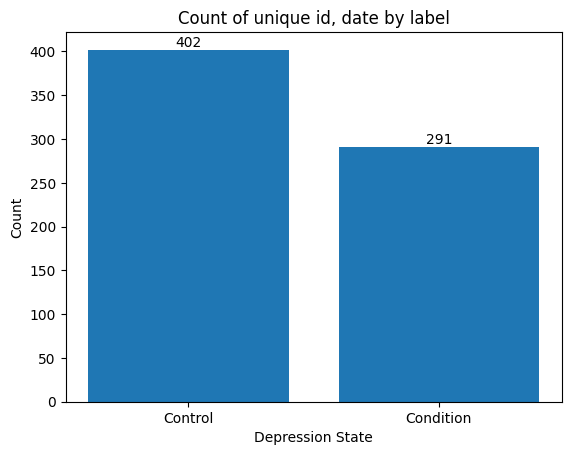

In [11]:
import matplotlib.pyplot as plt

# create a list of labels
labels = ['label 0', 'label 1']

# create a list of counts
counts = [len(df[df['label'] == 0].groupby(['id', 'date'])),
          len(df[df['label'] == 1].groupby(['id', 'date']))]

# create a bar plot
plt.bar(labels, counts)

# add labels and title
plt.xlabel('Depression State')
plt.ylabel('Count')
plt.title('Count of unique id, date by label')
# label 0 = control, label 1 = condition
plt.xticks([0, 1], ['Control', 'Condition'])

# remove gridlines
plt.grid(False)

# add total count on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# display the plot
plt.show()



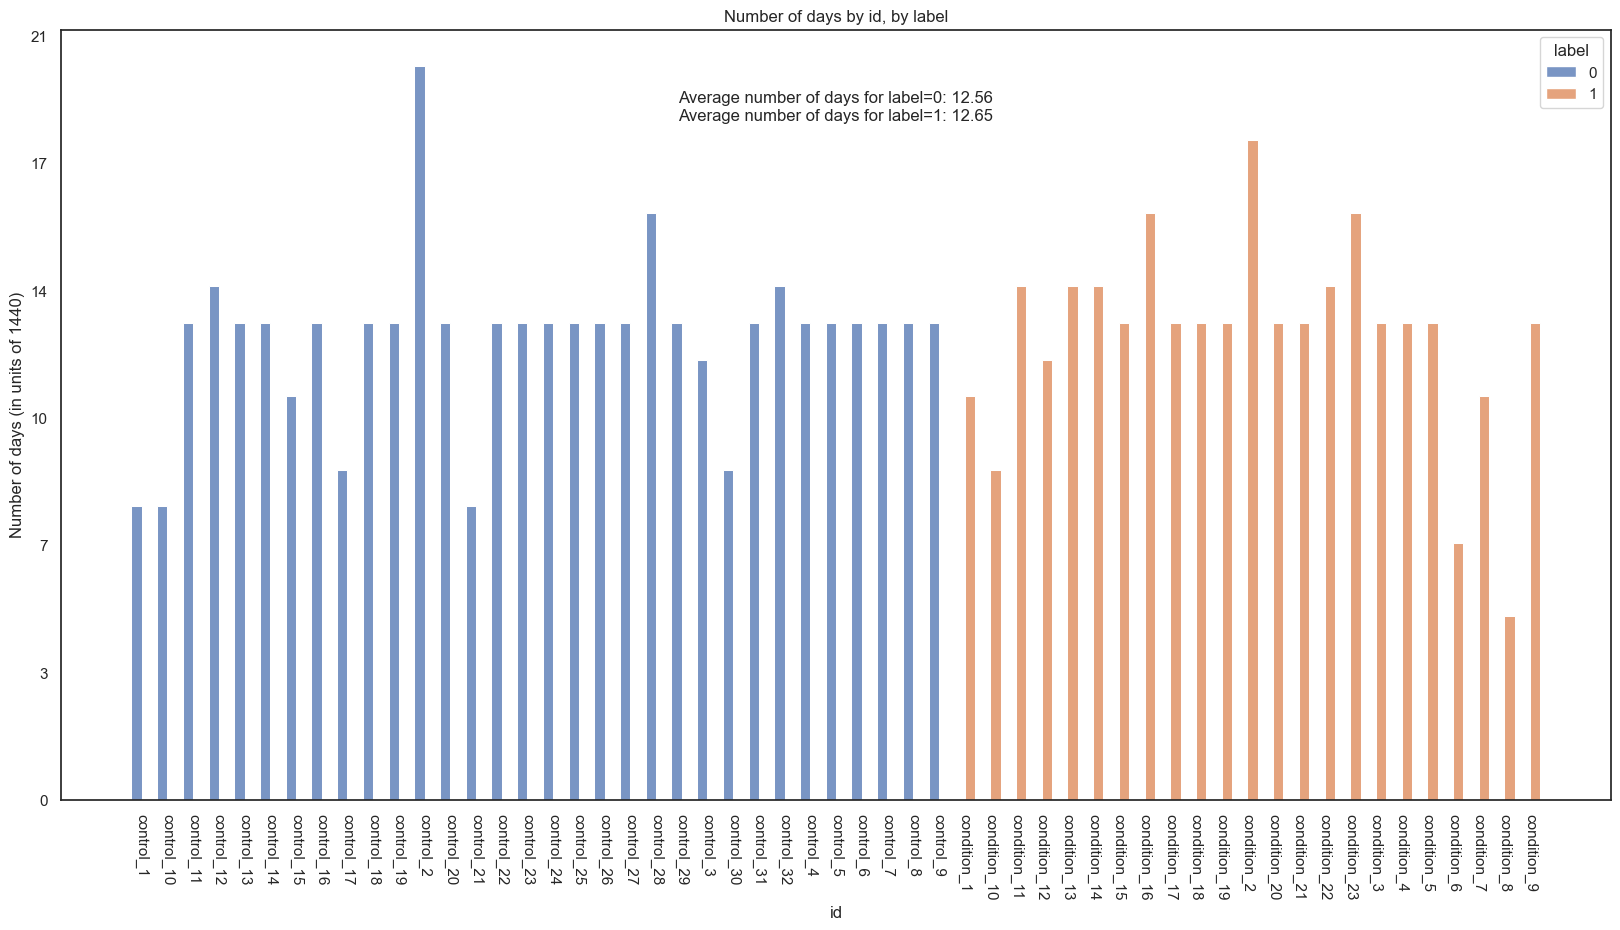

In [12]:
import matplotlib.ticker as ticker
import seaborn as sns

# plot histogram of days by id, by label
# set style
sns.set_theme(style="white")
plt.figure(figsize=(20,10))
sns.histplot(data=df, x='id', hue='label', multiple='dodge', shrink=.8)
plt.title('Number of days by id, by label')
plt.xticks(rotation=270)
plt.xlabel('id')
plt.ylabel('Number of days (in units of 1440)')

# FuncFormatter to format the y-axis labels into days
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1440))
plt.gca().yaxis.set_major_formatter(formatter)

# add text box with average number of days for each label
plt.text(0.5, 0.9, f"Average number of days for label=0: {df[df['label'] == 0].groupby('id').size().mean()/1440:.2f}\nAverage number of days for label=1: {df[df['label'] == 1].groupby('id').size().mean()/1440:.2f}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.show()



In [13]:
import pandas as pd


#  statistics for label 0 and 1
stats_0 = [df[df['label'] == 0].groupby('id').size().mean()/1440,
           df[df['label'] == 0].groupby('id').size().std()/1440,
           df[df['label'] == 0].groupby('id').size().max()/1440,
           df[df['label'] == 0].groupby('id').size().min()/1440]

stats_1 = [df[df['label'] == 1].groupby('id').size().mean()/1440,
           df[df['label'] == 1].groupby('id').size().std()/1440,
           df[df['label'] == 1].groupby('id').size().max()/1440,
           df[df['label'] == 1].groupby('id').size().min()/1440]

# round to 1 decimal
stats_0 = [round(stat, 1) for stat in stats_0]
stats_1 = [round(stat, 1) for stat in stats_1]

# dataFrame
stats_df = pd.DataFrame({'Control (label=0)': stats_0, 'Condition (label=1)': stats_1},
                        index=['Average', 'SD', 'Max', 'Min'])

# print
print(stats_df)


         Control (label=0)  Condition (label=1)
Average               12.6                 12.7
SD                     2.3                  2.8
Max                   20.0                 18.0
Min                    8.0                  5.0


In [14]:
from sklearn.preprocessing import StandardScaler

# normalise the activity column
scaler = StandardScaler()
df['activity_norm'] = scaler.fit_transform(df[['activity']])

# extract day of the week (0 = Monday, 6 = Sunday) and hour of the day (0 to 23)
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour_of_day'] = df['timestamp'].dt.hour

# split df by label 
control = df[df['label'] == 0]
condition = df[df['label'] == 1]

# pivot table to reshape the data for the heatmap
control_hm = control.pivot_table(index='hour_of_day', columns='day_of_week', values='activity', aggfunc='mean')
condition_hm = condition.pivot_table(index='hour_of_day', columns='day_of_week', values='activity', aggfunc='mean')

# pivot table to reshape the data for the heatmap - normalised
control_hm_norm = control.pivot_table(index='hour_of_day', columns='day_of_week', values='activity_norm', aggfunc='mean')
condition_hm_norm = condition.pivot_table(index='hour_of_day', columns='day_of_week', values='activity_norm', aggfunc='mean')

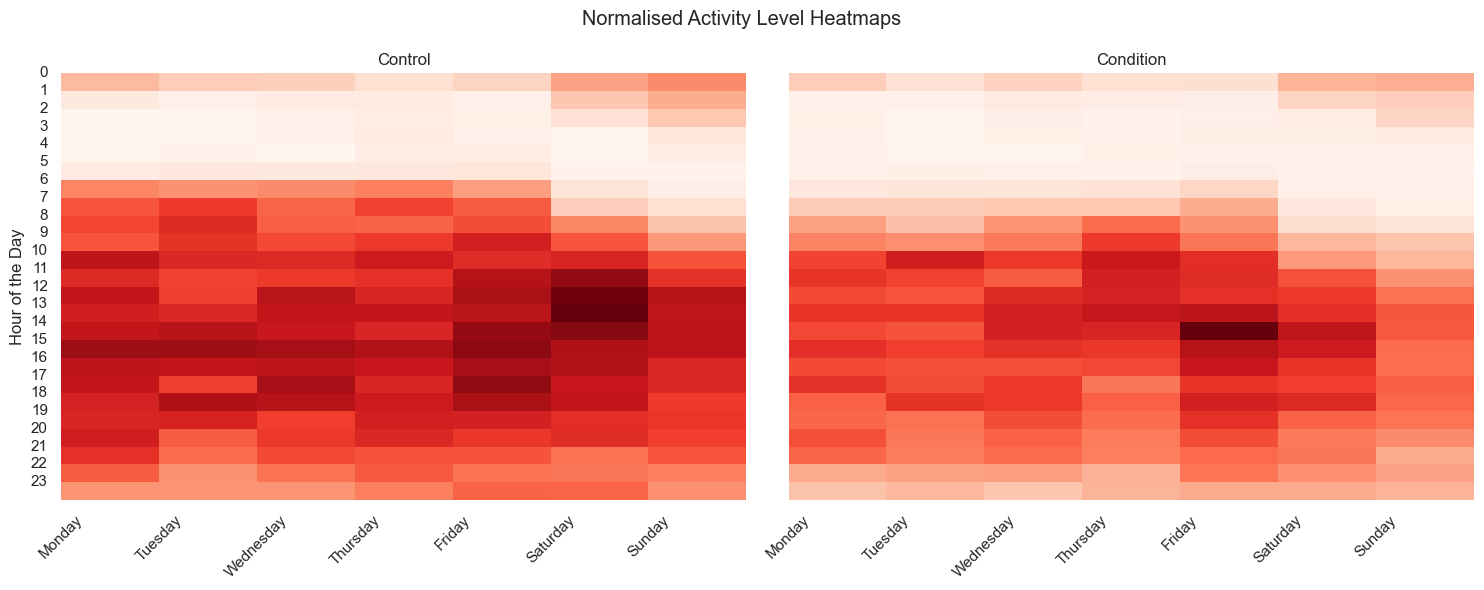

In [15]:
import seaborn as sns
import calendar
import matplotlib.pyplot as plt

# plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# control heatmap
sns.heatmap(control_hm_norm, cmap='Reds', annot=False, fmt='.2f', cbar=False, ax=axs[0])
#axs[0].set_xlabel('Day of the Week')
axs[0].set_xlabel('')
axs[0].set_ylabel('Hour of the Day')
axs[0].set_title('Control')
axs[0].set_yticks(range(0, 24))
axs[0].set_yticklabels(range(0, 24), rotation=0)  
axs[0].set_xticks(range(7))
axs[0].set_xticklabels(calendar.day_name, rotation=45)

# condition heatmap
sns.heatmap(condition_hm_norm, cmap='Reds', annot=False, fmt='.2f', cbar=False, ax=axs[1])
#axs[1].set_xlabel('Day of the Week')
axs[1].set_xlabel('')
#axs[1].set_ylabel('Hour of the Day')
axs[1].set_ylabel('') 
axs[1].set_title('Condition')
axs[1].set_yticks(range(0, 24))
#axs[1].set_yticklabels(range(0, 24), rotation=0)
axs[1].set_xticks(range(7))
axs[1].set_xticklabels(calendar.day_name, rotation=45)

# add shared title
plt.suptitle('Normalised Activity Level Heatmaps')

plt.tight_layout()
plt.show()

## Descriptive Statistics

In [16]:
# count of unique id, date by label
print("\nCount of unique id, date by label:\n")
# label 0
print("Control: ", len(df[df['label'] == 0].groupby(['id', 'date'])))
# label 1
print("Condition: ", len(df[df['label'] == 1].groupby(['id', 'date'])))


Count of unique id, date by label:

Control:  402
Condition:  291


In [17]:
# print date range
print(f"Overall date range: {df['timestamp'].min()} to {df['timestamp'].max()}\n")
# print number of unique days
print(f"Number of unique days: {df['timestamp'].dt.date.nunique()}\n")
# print number of unique hours
print(f"Number of unique hours: {df['timestamp'].dt.hour.nunique()}\n")
# print number of unique ids
print(f"Number of unique ids: {df['id'].nunique()}\n")
# print averge number of days per id for each label
print("Average number of days per id for each label: ")
print(df.groupby("label")['date'].nunique() / df.groupby("label")['id'].nunique())


Overall date range: 2002-05-25 00:00:00 to 2006-02-08 23:59:00

Number of unique days: 413

Number of unique hours: 24

Number of unique ids: 55

Average number of days per id for each label: 
label
0     6.375000
1    10.173913
dtype: float64


In [18]:
# descriptive statistics
df.describe()[['activity', 'activity_norm']]

,activity,activity_norm
count,997920.000000,9.979200e+05
mean,242.180715,2.050628e-17
min,0.000000,-6.089545e-01
25%,0.000000,-6.089545e-01
50%,52.000000,-4.782024e-01
75%,337.000000,2.384196e-01
max,8000.000000,1.950675e+01
std,397.699374,1.000001e+00


In [19]:
# describe data by label
print(df.groupby("label", observed=False)[['activity']].describe())
print(df.groupby("label", observed=False)[['activity_norm']].describe())



       activity                                                       
          count        mean         std  min  25%   50%    75%     max
label                                                                 
0      578880.0  285.012894  434.072396  0.0  0.0  93.0  410.0  8000.0
1      419040.0  183.010488  332.167673  0.0  0.0  17.0  227.0  8000.0
      activity_norm                                                    \
              count      mean       std       min       25%       50%   
label                                                                   
0          578880.0  0.107700  1.091459 -0.608955 -0.608955 -0.375109   
1          419040.0 -0.148781  0.835223 -0.608955 -0.608955 -0.566209   

                            
            75%        max  
label                       
0      0.421975  19.506752  
1     -0.038171  19.506752  


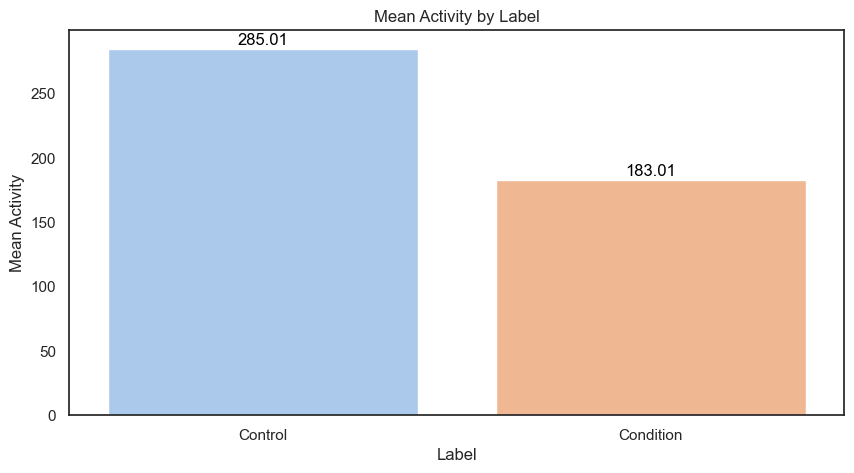

In [20]:
# bar plot mean activity by label
import matplotlib.pyplot as plt
import seaborn as sns

# average activity by label
mean_act_label = df.groupby('label', observed=False)['activity'].mean()

# set style
sns.set_theme(style="white")
plt.figure(figsize=(10,5))

# bar plot with accessible colors
bar_plot = sns.barplot(x=mean_act_label.index, y=mean_act_label.values, hue = mean_act_label.index, legend=False, palette='pastel')

plt.title('Mean Activity by Label')
plt.xlabel('Label')
plt.ylabel('Mean Activity')

# label 0 = control, label 1 = condition
plt.xticks([0, 1], ['Control', 'Condition'])

# add data labels
for i, v in enumerate(mean_act_label.values):
    bar_plot.text(i, v + 3, round(v, 2), color='black', ha="center")

plt.show()



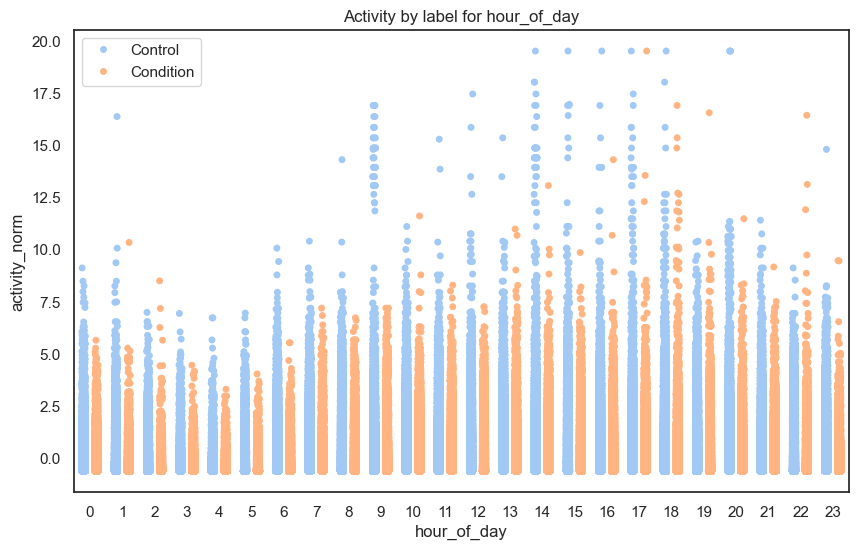

In [21]:
# create the plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(x="hour_of_day", y="activity_norm", hue="label", data=df, jitter=True, dodge=True, palette = 'pastel')

# set title
plt.title("Activity by label for hour_of_day")

# set legend labels
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Control', 'Condition'])

# show plot
plt.show()


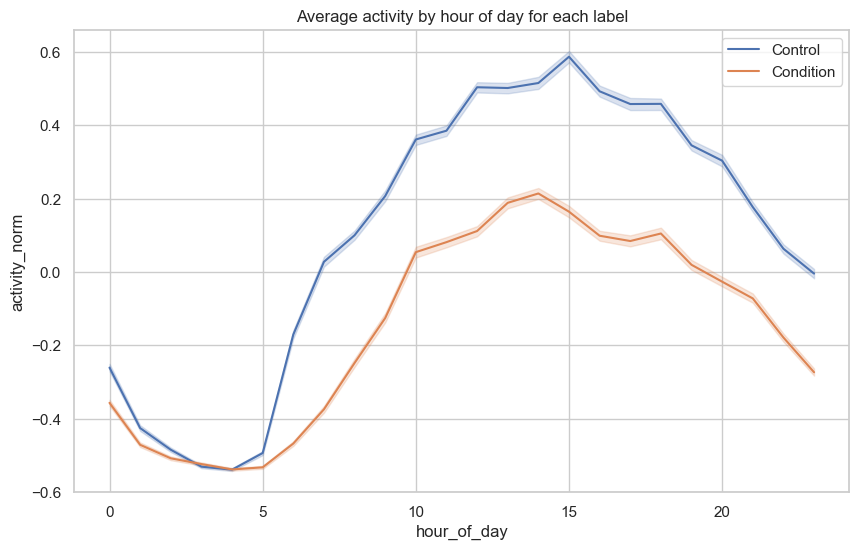

In [22]:
# plot average activity by hour of day for each label
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="hour_of_day", y="activity_norm", hue="label", data=df)
plt.title("Average activity by hour of day for each label")

# get the legend
legend = ax.legend()

# change the legend text for each label
legend.texts[0].set_text('Control')
legend.texts[1].set_text('Condition')

plt.show()


### T-test between groups

In [23]:
# evaluate if there is a difference between labels with t-test
alpha = 0.05
from scipy.stats import ttest_ind
# t-test
t_stat, p_val = ttest_ind(df[df['label'] == 0]['activity_norm'], df[df['label'] == 1]['activity_norm'])
print(f"t-statistic: {t_stat:.2f}, p-value: {p_val:.2f}")

# interpret the p-value
if p_val < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means of the two groups.")




t-statistic: 127.48, p-value: 0.00
Reject the null hypothesis: There is a significant difference between the means of the two groups.


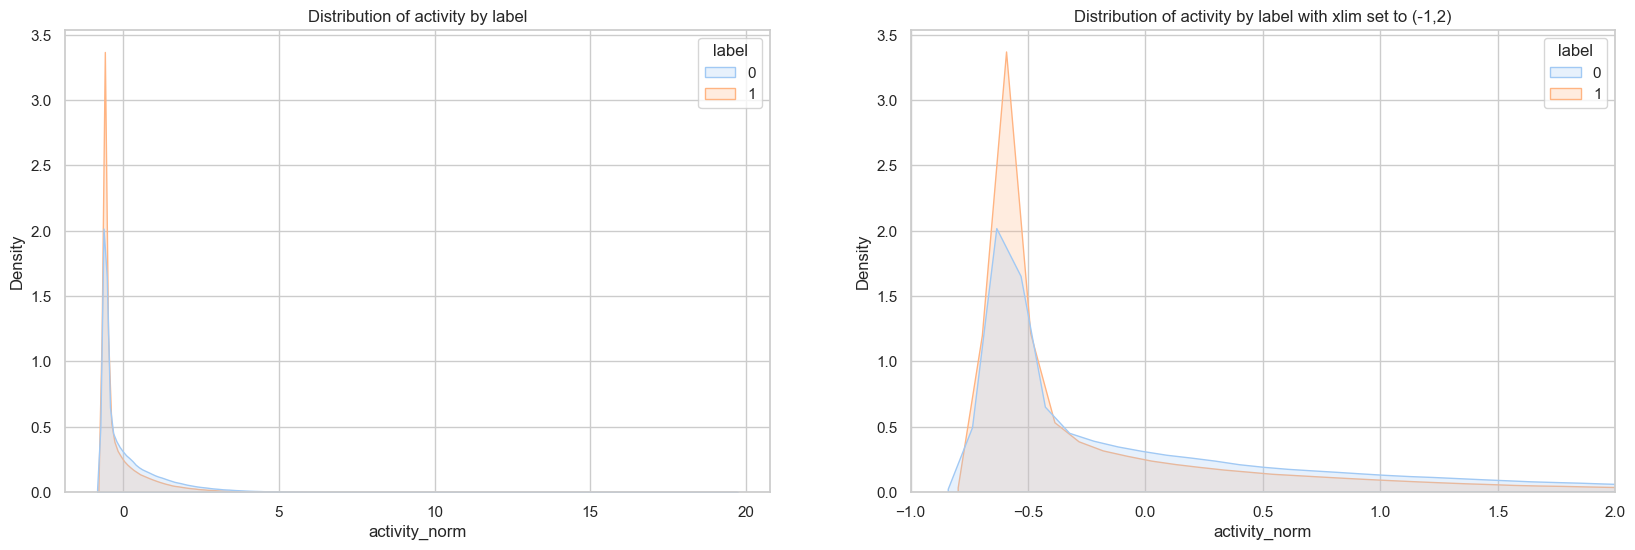

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# First plot
sns.kdeplot(data=df, x="activity_norm", hue="label", fill=True, common_norm=False, palette='pastel', ax=axs[0])
axs[0].set_title("Distribution of activity by label")

# Second plot with xlim set to (-1,2)
sns.kdeplot(data=df, x="activity_norm", hue="label", fill=True, common_norm=False, palette='pastel', ax=axs[1])
axs[1].set_xlim(-1, 2)
axs[1].set_title("Distribution of activity by label with xlim set to (-1,2)")

plt.show()


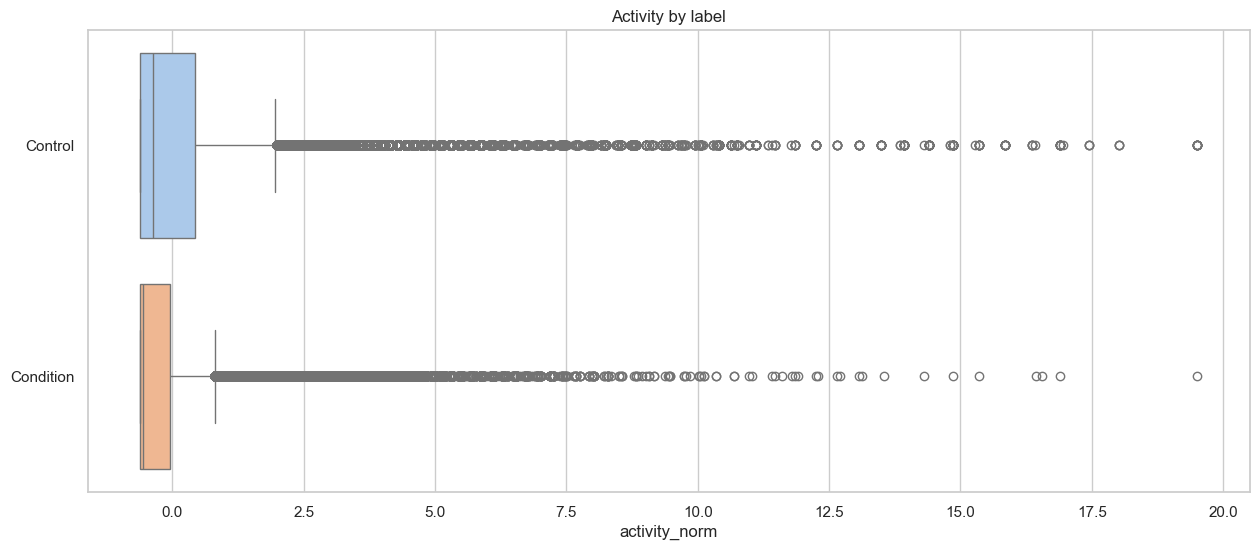

In [25]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 6))  # Adjust the figure size
ax = sns.boxplot(y="label", x="activity_norm", data=df, hue = 'label', legend= False, palette='pastel', orient='h')
# labels
ax.set_yticks([0, 1]) 
ax.set_yticklabels(['Control', 'Condition'])
# remove the y-axis label
ax.set_ylabel('') 
plt.title("Activity by label")
plt.show()


In [26]:
# save to CSV
output_csv_path = '../data/petter/eda.csv'
df.to_csv(output_csv_path, index=False)

## Male / Female and Age EDA

### Add sex to df

In [91]:
def add_scores(df, scores_df, merge_on_df='id', merge_on_scores='number', save_to_csv=False, output_csv_path=None, include_all_labels=True):
    """
    Adds scores data.

    Args:
        df (pd.DataFrame): extracted df.
        scores_df (pd.DataFrame):  scores df
        merge_on_df (str, optional): col in extracted df to merge on. defaults to 'id'.
        merge_on_scores (str, optional): col in scores df to merge on. defaults to 'number'.
        save_to_csv (bool, optional): save the updated df to a CSV file? defaults to False.
        output_csv_path (str, optional): csv filepath. required if save_to_csv is True.
        include_all_labels (bool, optional): include all labels. defaults to True. set to False to filter only label=1.

    Returns:
        pd.DataFrame: updated df with scores added.
    """

    import pandas as pd
    try:
        # merge based on specified columns
        merged_df = pd.merge(df, scores_df, left_on=merge_on_df, right_on=merge_on_scores, how='left')
        # Fill missing values with NaN
        merged_df.fillna(value=pd.NA, inplace=True)

        # filter rows based on label
        if 'label' in merged_df.columns:
            if not include_all_labels:
                merged_df = merged_df[merged_df['label'] == 1]

        if save_to_csv:
            if output_csv_path:
                merged_df.to_csv(output_csv_path, index=False)
                print(f"Updated df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        return merged_df
    except KeyError:
        print(f"Error: '{merge_on_df}' column not found in the specified DataFrames.")
        return merged_df

In [92]:
scores_csv_path = '../data/depresjon/scores.csv'
df2 = add_scores(df, scores_df=pd.read_csv(scores_csv_path), save_to_csv=True, output_csv_path='../data/petter/eda_sex.csv', include_all_labels=True)

Updated df saved to ../data/petter/eda_sex.csv


In [98]:
# new df condition only
cond = df2[df2['label'] == 1]
cond.drop(df2.columns[[8, 9, 12, 13, 14, 15, 16, 17]], axis=1, inplace=True)
#print(cond.head())


C:\Users\zoona\AppData\Local\Temp\ipykernel_10708\4076838064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cond.drop(df2.columns[[8, 9, 12, 13, 14, 15, 16, 17]], axis=1, inplace=True)


In [30]:
# drop cols with index 8, 9, 12-19
cols = df2.columns[[8, 9, 12, 13, 14, 15, 16, 17, 18, 19]]
df2.drop(cols, axis=1, inplace=True)
#print(df2.info())

In [44]:
# create df with unique ids, age, sex, and label
df3 = df2[['id', 'age', 'gender', 'label']].drop_duplicates()


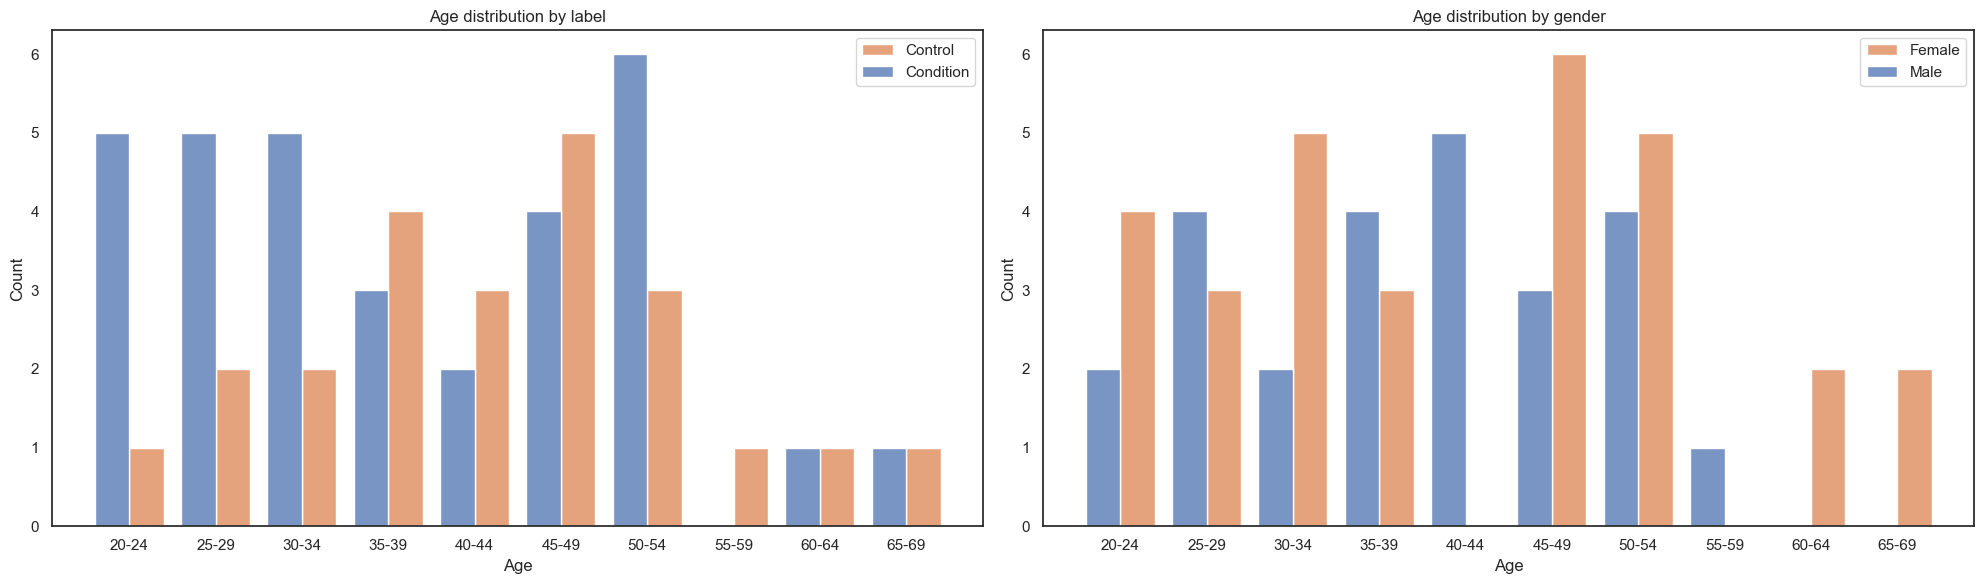

In [76]:
# age correct order
age_order = ['20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69']

# 'age' column to a category type 
df3['age'] = pd.Categorical(df3['age'], categories=age_order, ordered=True)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# participants by label 
sns.histplot(data=df3, x='age', hue='label', multiple='dodge', shrink=.8, ax=axs[0])
axs[0].set_title('Age distribution by label')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Count')
# add legend where label 0 = control, label 1 = condition
axs[0].legend(['Control', 'Condition'])


# participants by gender
sns.histplot(data=df3, x='age', hue='gender', multiple='dodge', shrink=.8, ax=axs[1])
axs[1].set_title('Age distribution by gender')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Count')
# add legend where gender 1 = female, gender 2 = male
axs[1].legend(['Female', 'Male'])

plt.tight_layout()
plt.show()





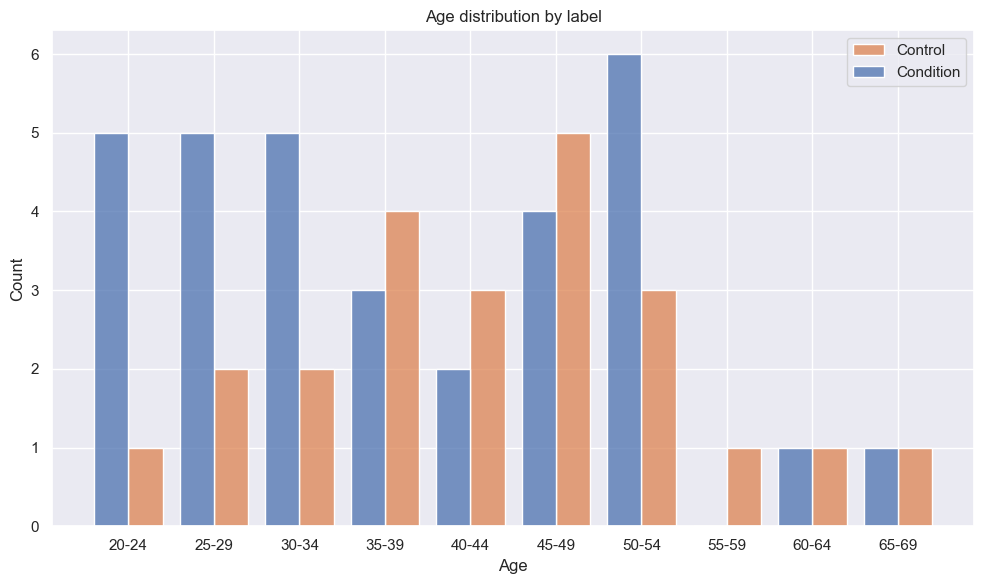

In [90]:
fig, axs = plt.subplots(figsize=(10, 6))

# participants by label 
sns.histplot(data=df3, x='age', hue='label', multiple='dodge', shrink=.8, ax=axs)
axs.set_title('Age distribution by label')
axs.set_xlabel('Age')
axs.set_ylabel('Count')
# add legend where label 0 = control, label 1 = condition
axs.legend(['Control', 'Condition'])

plt.tight_layout()
plt.show()

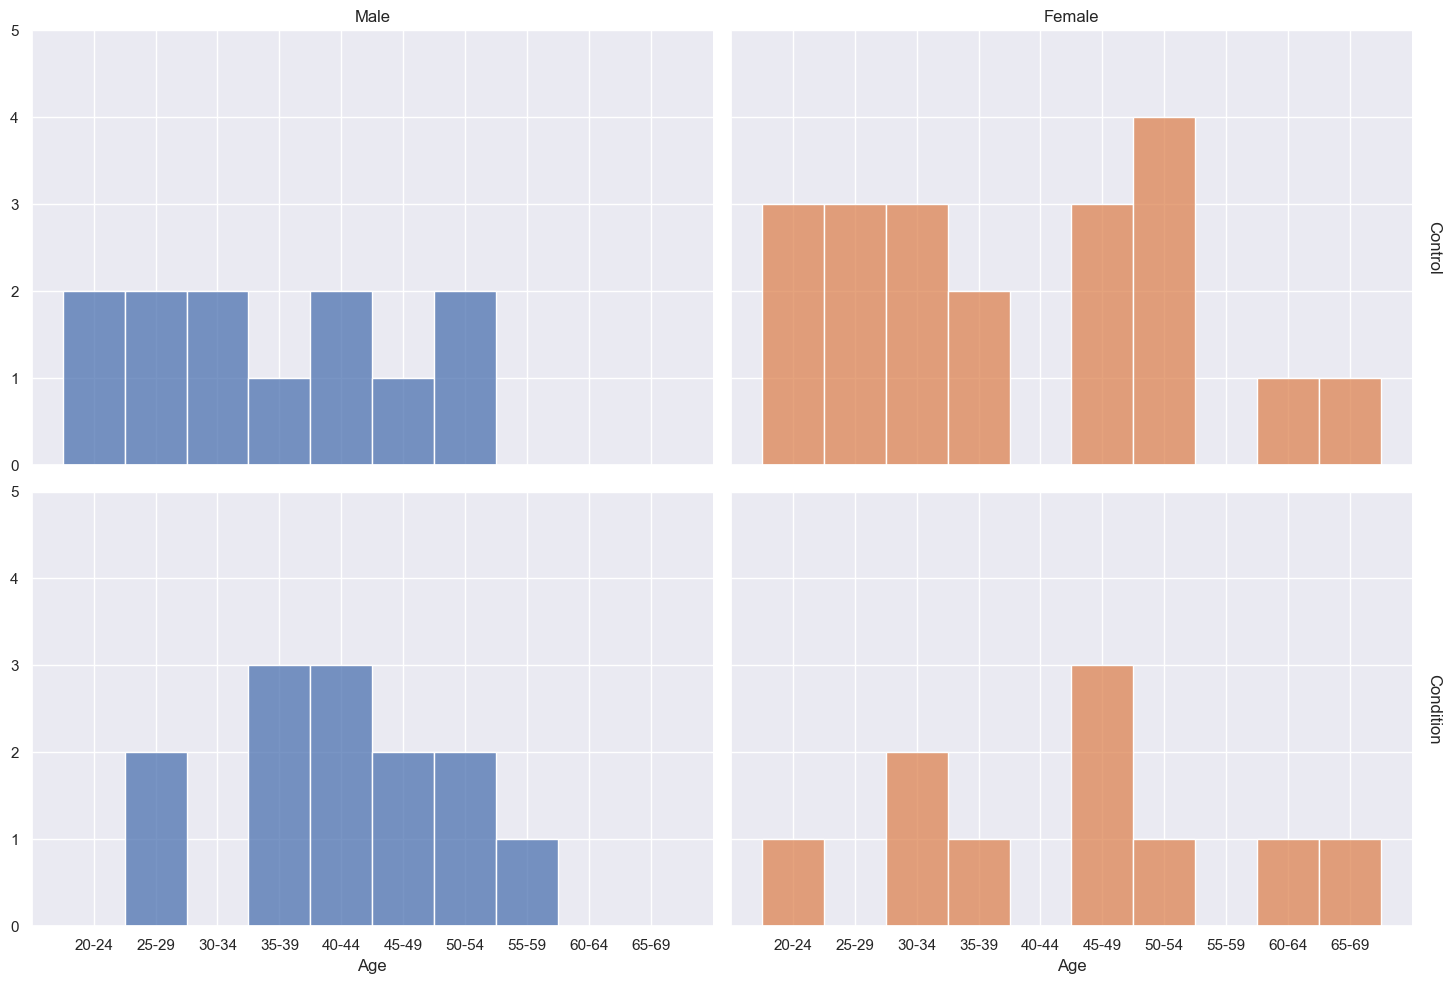

In [84]:
# 'gender' and 'label' with descriptive labels
df3['gender'] = df3['gender'].replace({1: 'Female', 2: 'Male'})
df3['label'] = df3['label'].replace({0: 'Control', 1: 'Condition'})

import seaborn as sns
import matplotlib.pyplot as plt

# set style
sns.set_theme(style="darkgrid")

# facet grid 
g = sns.FacetGrid(df3, col='gender', row='label', hue='gender', margin_titles=True, height=5, aspect=1.5)

# histogram to each facet
g.map(sns.histplot, 'age', bins=20)

# set y-axis ticks
for ax in g.axes.flat:
    ax.set_yticks([0, 1, 2, 3, 4, 5])

# legend
#g.add_legend(title='Gender')

# axis labels
g.set_axis_labels('Age', '')

# facet titles
g.set_titles(col_template='{col_name}', row_template='{row_name}')

plt.show()


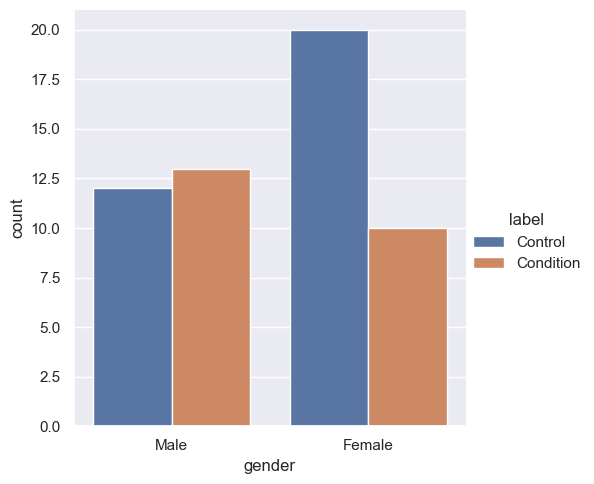

In [88]:
# gender balance by condition
sns.catplot(x="gender", hue="label", kind="count", data=df3)
plt.show()

In [31]:
# create male, female df - gender == 1 is female, gender == 2 is male
male = df2[df2['gender'] == 2]
female = df2[df2['gender'] == 1]

In [32]:
# count of unique id, date by label
print("\nCount of unique id, date by label for Male:\n")
# label 0
print("Control: ", len(male[male['label'] == 0].groupby(['id', 'date'])))
# label 1
print("Condition: ", len(male[male['label'] == 1].groupby(['id', 'date'])))

# count of unique id, date by label
print("\nCount of unique id, date by label for Female:\n")
# label 0
print("Control: ", len(female[female['label'] == 0].groupby(['id', 'date'])))
# label 1
print("Condition: ", len(female[female['label'] == 1].groupby(['id', 'date'])))


Count of unique id, date by label for Male:

Control:  150
Condition:  160

Count of unique id, date by label for Female:

Control:  252
Condition:  131


In [82]:
# descriptive statistics
print(male.describe()[['activity', 'activity_norm']])
print(female.describe()[['activity', 'activity_norm']])

            activity  activity_norm
count  446400.000000  446400.000000
mean      227.770609      -0.036234
min         0.000000      -0.608955
25%         0.000000      -0.608955
50%        52.000000      -0.478202
75%       315.000000       0.183101
max      8000.000000      19.506752
std       378.264945       0.951133
            activity  activity_norm
count  551520.000000  551520.000000
mean      253.844247       0.029328
min         0.000000      -0.608955
25%         0.000000      -0.608955
50%        52.000000      -0.478202
75%       357.000000       0.288709
max      8000.000000      19.506752
std       412.391863       1.036944


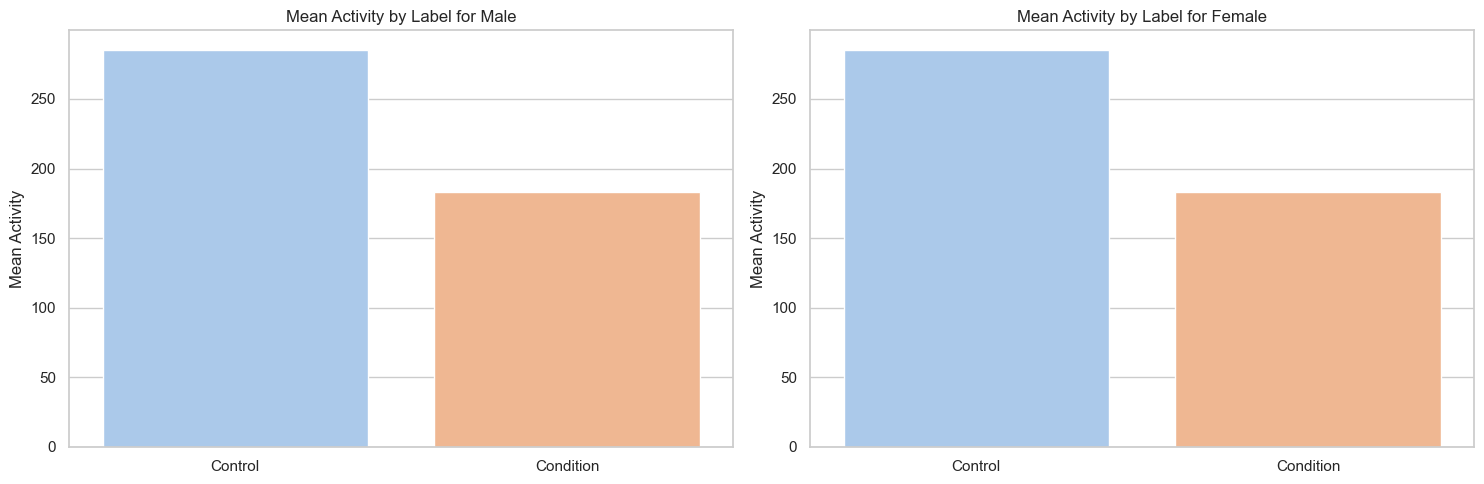

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# male
sns.barplot(x=mean_act_label.index, y=mean_act_label.values, hue = mean_act_label.index, legend=False, palette='pastel', ax=axs[0])
axs[0].set_title('Mean Activity by Label for Male')
axs[0].set_xlabel('')
axs[0].set_ylabel('Mean Activity')
axs[0].set_xticks([0, 1], ['Control', 'Condition'])

# female
sns.barplot(x=mean_act_label.index, y=mean_act_label.values, hue = mean_act_label.index, legend=False, palette='pastel', ax=axs[1])
axs[1].set_title('Mean Activity by Label for Female')
axs[1].set_xlabel('')
axs[1].set_ylabel('Mean Activity')
axs[1].set_xticks([0, 1], ['Control', 'Condition'])

plt.tight_layout()
plt.show()



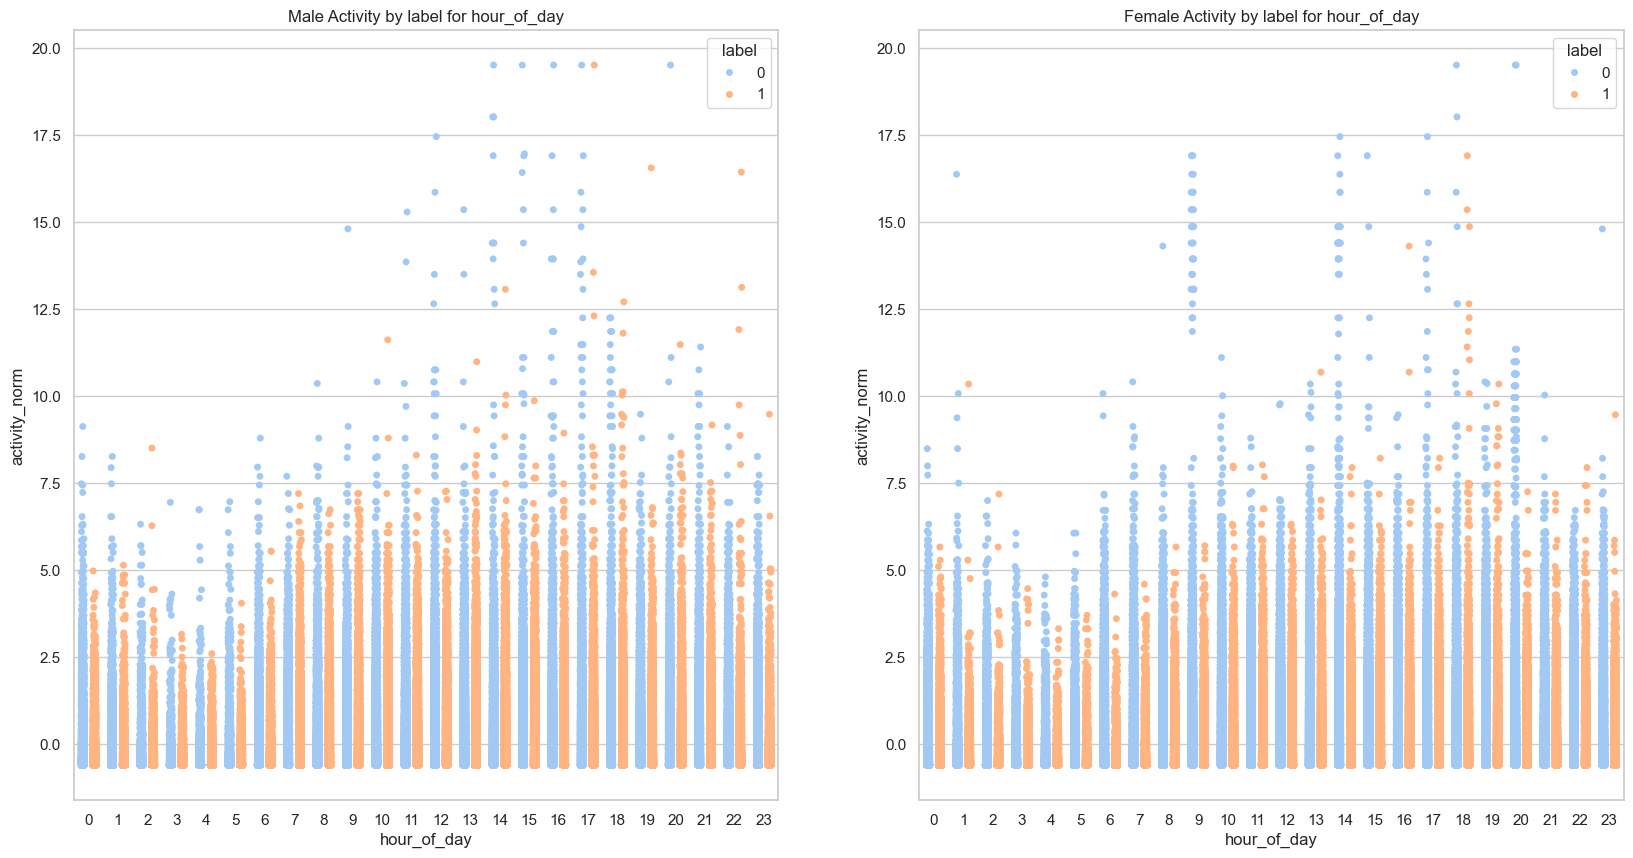

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axs = plt.subplots(ncols=2, figsize=(20, 10))

#  male 
sns.stripplot(x="hour_of_day", y="activity_norm", hue="label", data=male, jitter=True, dodge=True, palette = 'pastel', ax=axs[0])
axs[0].set_title('Male Activity by label for hour_of_day')

# P female 
sns.stripplot(x="hour_of_day", y="activity_norm", hue="label", data=female, jitter=True, dodge=True, palette = 'pastel', ax=axs[1])
axs[1].set_title('Female Activity by label for hour_of_day')

#  plot
plt.show()


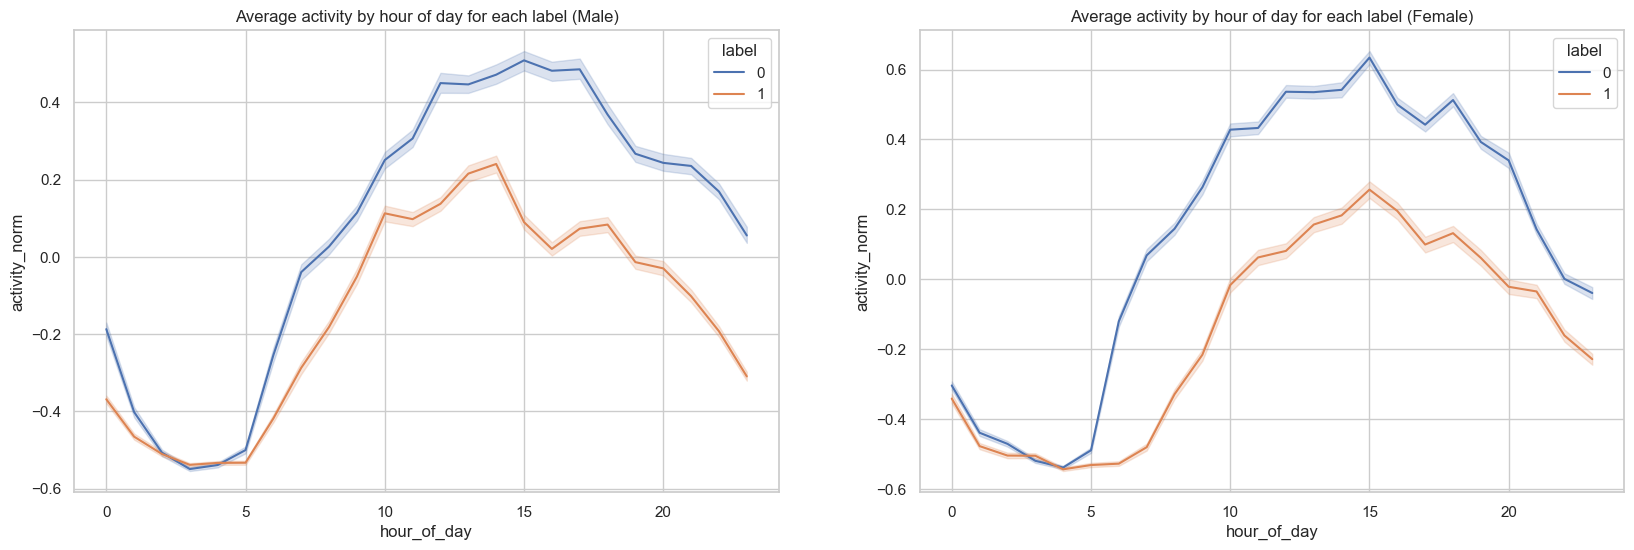

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
# theme
sns.set_theme(style="whitegrid")

# figure and a set of subplots
fig, axs = plt.subplots(ncols=2, figsize=(20, 6))

#  average activity by hour of day for each label for male
sns.lineplot(x="hour_of_day", y="activity_norm", hue="label", data=male, ax=axs[0])
axs[0].set_title("Average activity by hour of day for each label (Male)")

# average activity by hour of day for each label for female
sns.lineplot(x="hour_of_day", y="activity_norm", hue="label", data=female, ax=axs[1])
axs[1].set_title("Average activity by hour of day for each label (Female)")

plt.show()


### T-test between groups

In [87]:
# evaluate if there is a difference between genders with t-test
alpha = 0.05
from scipy.stats import ttest_ind
# t-test
t_stat, p_val = ttest_ind(df2[df2['gender'] == 1]['activity_norm'], df2[df2['gender'] == 2]['activity_norm'])
print(f"t-statistic: {t_stat:.2f}, p-value: {p_val:.2f}")

# interpret the p-value
if p_val < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means of the two groups.")


t-statistic: 32.58, p-value: 0.00
Reject the null hypothesis: There is a significant difference between the means of the two groups.


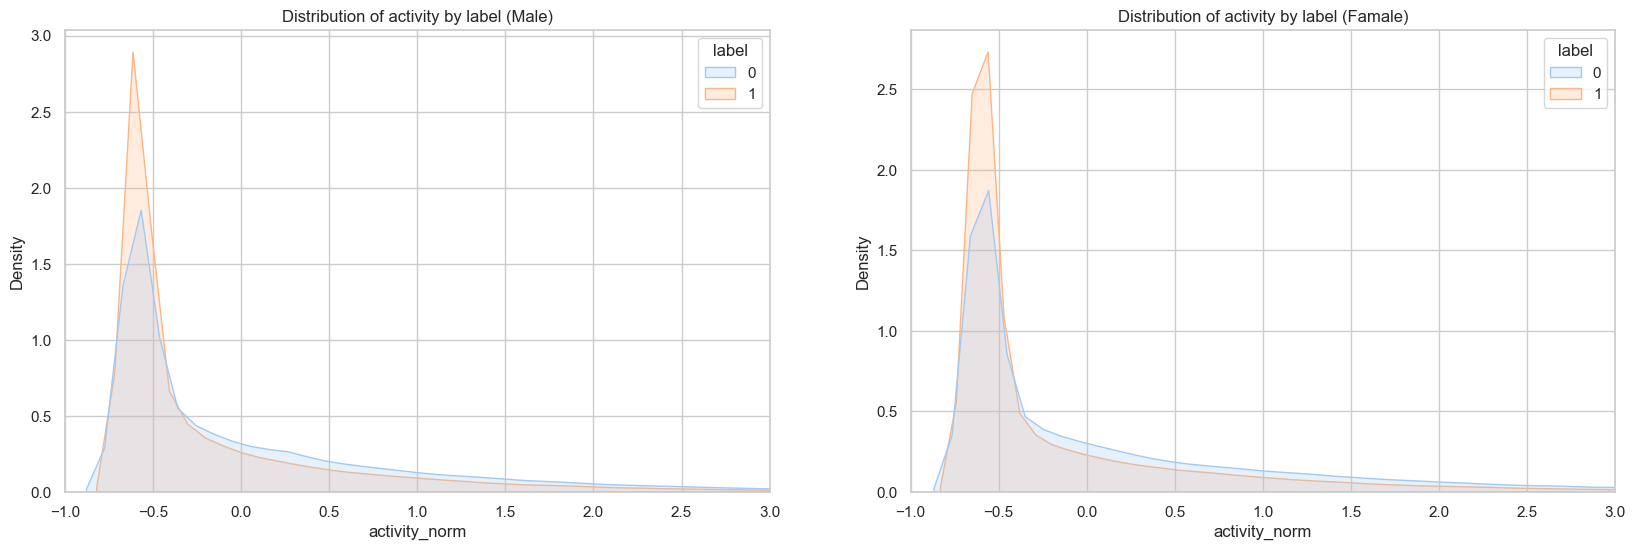

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# male plot
sns.kdeplot(data=male, x="activity_norm", hue="label", fill=True, common_norm=False, palette='pastel', ax=axs[0])
axs[0].set_title("Distribution of activity by label (Male) with xlim set to (-1,3)")
axs[0].set_xlim(-1, 3)  

# female
sns.kdeplot(data=female, x="activity_norm", hue="label", fill=True, common_norm=False, palette='pastel', ax=axs[1])
axs[1].set_xlim(-1, 3)
axs[1].set_title("Distribution of activity by label (Famale) with xlim set to (-1,3)")

plt.show()


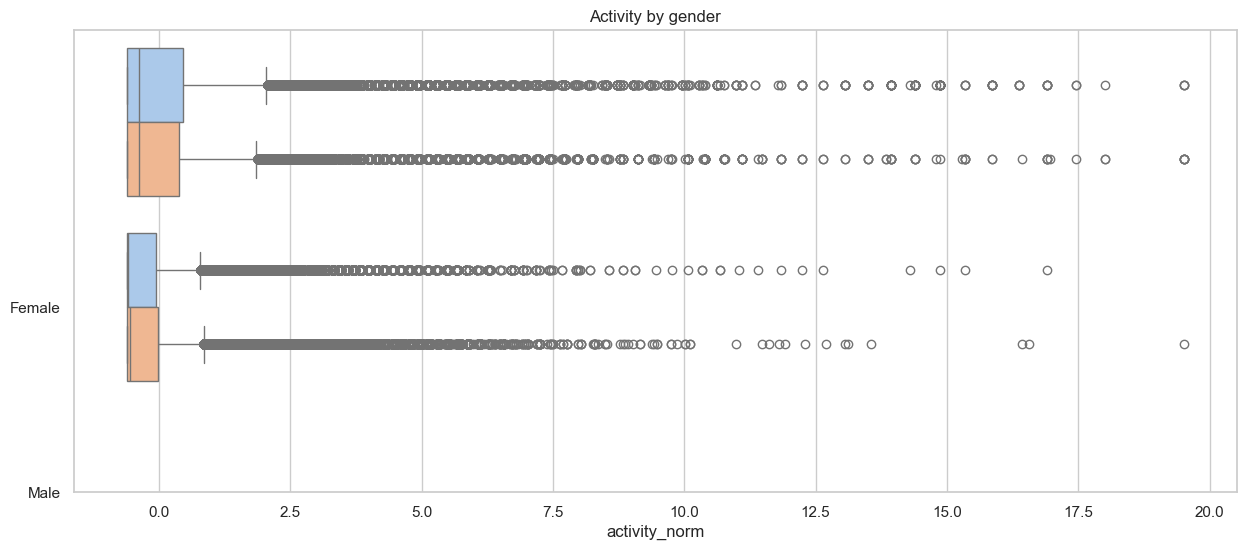

In [91]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 6))  # Adjust the figure size
ax = sns.boxplot(y="label", x="activity_norm", data=df2, hue = 'gender', legend= False, palette='pastel', orient='h')
# labels
ax.set_yticks([1, 2]) 
ax.set_yticklabels(['Female', 'Male'])
# remove the y-axis label
ax.set_ylabel('') 
plt.title("Activity by gender")
plt.show()


## MADRS

In [99]:
print(cond.info())

<class 'pandas.core.frame.DataFrame'>
Index: 419040 entries, 578880 to 997919
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   timestamp      419040 non-null  datetime64[ns]
 1   date           419040 non-null  datetime64[ns]
 2   activity       419040 non-null  int64         
 3   id             419040 non-null  object        
 4   label          419040 non-null  int64         
 5   activity_norm  419040 non-null  float64       
 6   day_of_week    419040 non-null  int32         
 7   hour_of_day    419040 non-null  int32         
 8   gender         419040 non-null  int64         
 9   age            419040 non-null  object        
 10  madrs1         419040 non-null  float64       
 11  madrs2         419040 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int32(2), int64(3), object(2)
memory usage: 38.4+ MB
None


In [101]:
# paired t-test for madrs scores 
from scipy.stats import ttest_rel
# t-test
t_stat, p_val = ttest_rel(cond['madrs1'], cond['madrs2'])
# print results and interpretation
print(f"t-statistic: {t_stat:.2f}, p-value: {p_val:.2f}")
if p_val < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means of the two groups.")


t-statistic: 437.52, p-value: 0.00
Reject the null hypothesis: There is a significant difference between the means of the two groups.


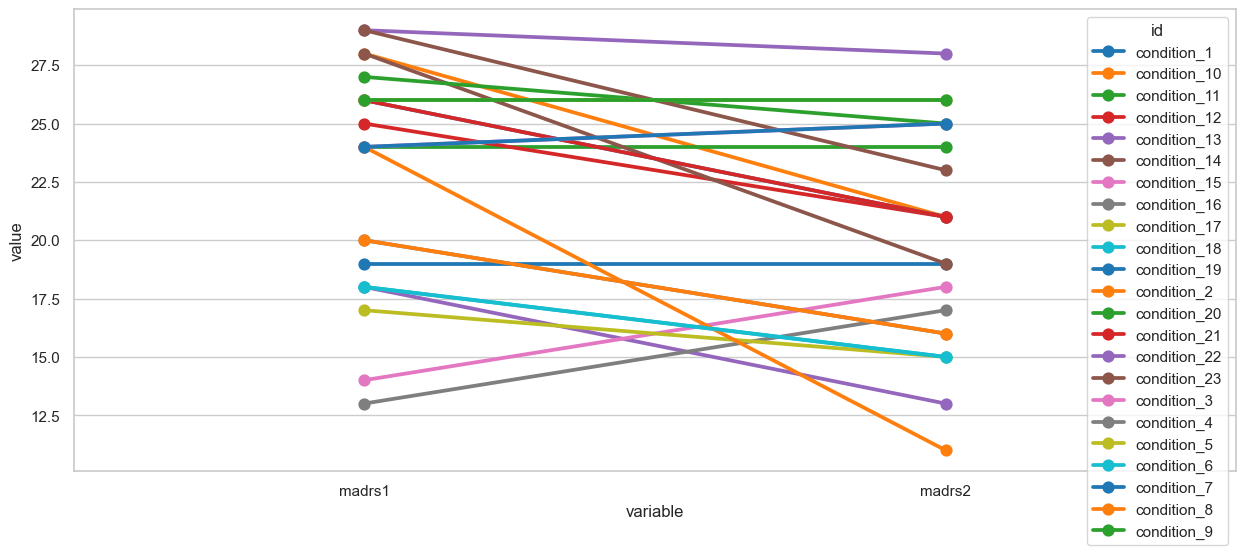

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# melt the df to long format
df_melt = pd.melt(cond, id_vars='id', value_vars=['madrs1', 'madrs2'])

# theme
sns.set_theme(style="whitegrid")

# figure and axes
plt.figure(figsize=(15, 6))

# pointplot
sns.pointplot(data=df_melt, x='variable', y='value', hue='id', palette='tab10')

plt.show()

